# Boyer Romain - Dechorgnat Paul - Kallala Inès - Ouahes Iza
# Kaggle - Titanic
## I - Libraries & Files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json
from operator import itemgetter

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier

C:\Users\izaou\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor, KDTree
from sklearn.svm import SVC

In [4]:
train_url = "Data/train.csv"
train = pd.read_csv(train_url,sep=';',skipinitialspace=True)
test_url = "Data/test.csv"
test_users = pd.read_csv(test_url, sep=';', skipinitialspace=True)


In [5]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


## II - Data preprocessing & feature engineering
### 1 - Functions
#### Creating a crosstab function to plot a graph

In [6]:
def graph_crosstab(data = train, feature = 'Age', target_feature = 'Survived', normalize = False, title=1):
    mat=pd.crosstab(data[feature], data[target_feature], normalize=normalize)
    mat.plot(kind = 'bar', figsize=(13.5/1.5, 6/1.5))
    if title==1:
        plt.title(feature)
    else:
        plt.title(title)
    plt.show()
    return

#### Creating function to transform string values into numerical values

In [7]:
def from_str_to_int(data, cat_index, cat, cat_dico, new_cat=''):
    if new_cat!='':
        for i in range(len(cat_index)):
            data.loc[data[cat]==cat_index[i], new_cat]=i
            cat_dico[cat_index[i]]=i
        cat_dico['Other']=len(cat_index)
    else:
        for i in range(len(cat_index)):
            data.loc[data[cat]==cat_index[i], cat]=i
            cat_dico[cat_index[i]]=i
    return

### 2 - First approach
#### Plot different graphs to get a first idea of the importance of a feature in survivability

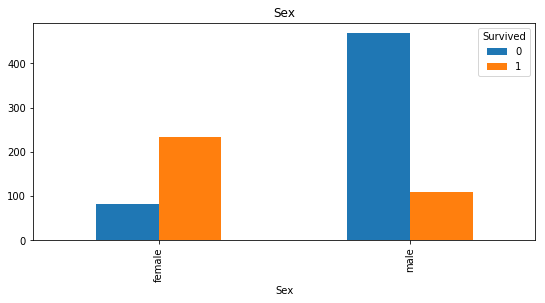

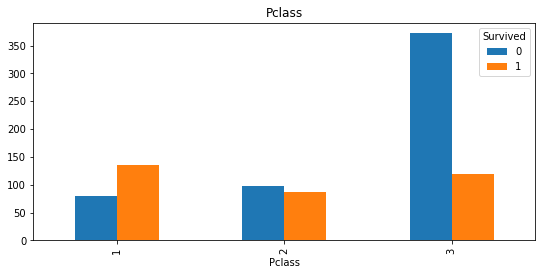

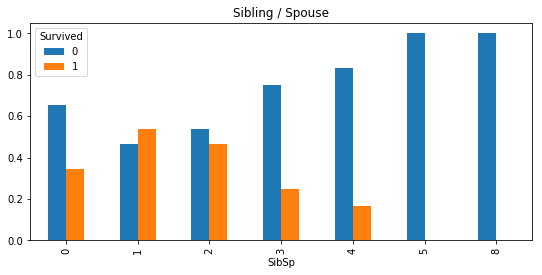

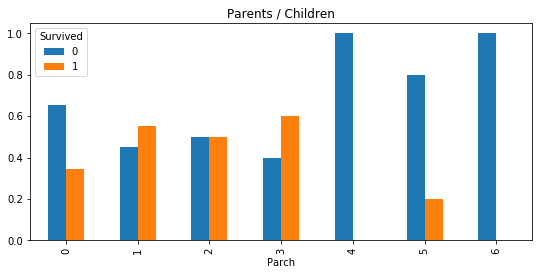

In [8]:
graph_crosstab(feature='Sex')
graph_crosstab(feature='Pclass')
graph_crosstab(feature='SibSp', normalize=0, title='Sibling / Spouse')
graph_crosstab(feature='Parch', normalize=0, title='Parents / Children')

#### Link between columns 'Pclass' & 'Fare'
#### Find the outliers in 'Fare'

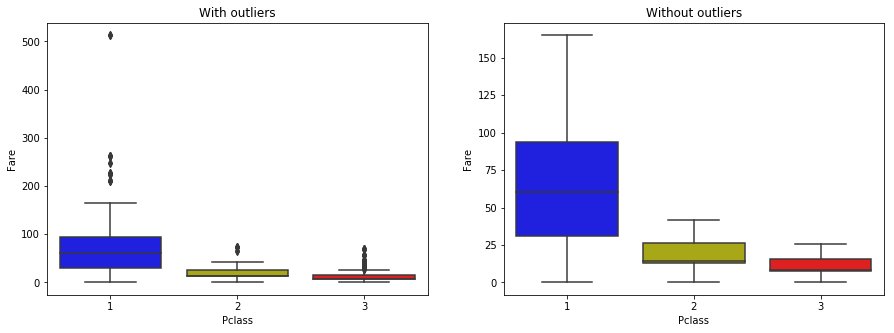

In [9]:
PClass_palette = {1:"b", 2:"y", 3:"r"}
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.boxplot( x=train["Pclass"], y=train["Fare"], palette=PClass_palette, showfliers=True)
plt.title('With outliers')

plt.subplot(1,2,2)
sns.boxplot( x=train["Pclass"], y=train["Fare"], palette=PClass_palette, showfliers=False)
plt.title('Without outliers')
plt.show()

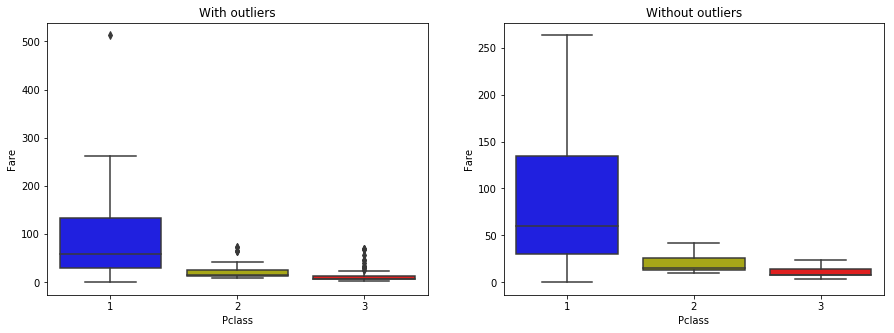

In [10]:
PClass_palette = {1:"b", 2:"y", 3:"r"}
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.boxplot( x=test_users["Pclass"], y=test_users["Fare"], palette=PClass_palette, showfliers=True)
plt.title('With outliers')

plt.subplot(1,2,2)
sns.boxplot( x=test_users["Pclass"], y=test_users["Fare"], palette=PClass_palette, showfliers=False)
plt.title('Without outliers')
plt.show()

### 3 - Create new columns
#### Create new 'Title' & 'Last_Name' columns from 'Name' column

In [11]:
def create_col_titre_name(data=train):
    data['Titre'] = data['Name'].apply(lambda x : str(x).split(',')[1].split('.')[0][1:])
    data['Titre'] = data['Titre'].astype('category')
    data['Last_Name'] = data['Name'].apply(lambda x : str(x).split(',')[0].replace(' ',''))
    return

create_col_titre_name(train)
create_col_titre_name(test_users)

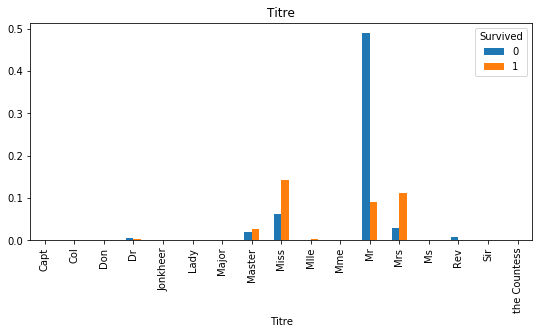

In [12]:
graph_crosstab(feature='Titre', normalize=True)

#### Create 5 groups with 'Title'

In [13]:
titre_index=['Mr','Miss','Mrs', 'Master']

train['Titre_int']=int(len(titre_index))
titre_dico=dict()
from_str_to_int(data=train, cat_index=titre_index, cat='Titre', cat_dico=titre_dico, new_cat='Titre_int')

test_users['Titre_int']=int(len(titre_index))
titre_dico_test=dict()
from_str_to_int(data=test_users, cat_index=titre_index, cat='Titre', cat_dico=titre_dico_test, new_cat='Titre_int')

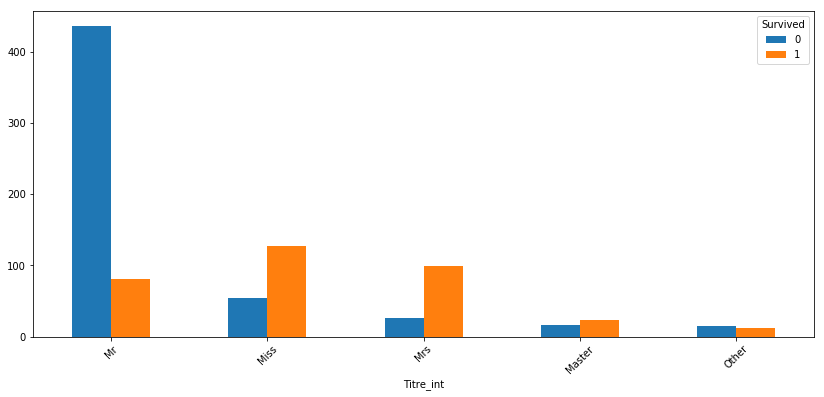

In [14]:
x=[0,1,2,3,4]
labels=['Mr','Miss','Mrs','Master','Other']

pd.crosstab(train['Titre_int'], train['Survived'], normalize=False).plot(kind='bar', figsize=(14,6))

plt.xticks(x, labels, rotation=45)

plt.show()

#### Create 'Family' column and 3 new groups (no family on board; 1,2 or 3 family members on board; more than 3 family member on board)

In [15]:
train['Family']=train['SibSp']+train['Parch']
test_users['Family']=test_users['SibSp']+test_users['Parch']

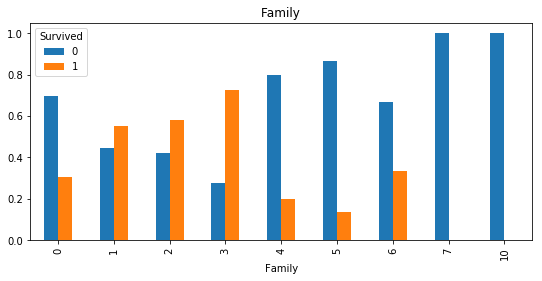

In [16]:
graph_crosstab(feature='Family', normalize=0)

In [17]:
train['Family_group']=int(2)
train.loc[train['Family']==0, 'Family_group']=0
train.loc[train['Family']==1, 'Family_group']=1
train.loc[train['Family']==2, 'Family_group']=1
train.loc[train['Family']==3, 'Family_group']=1

test_users['Family_group']=int(2)
test_users.loc[test_users['Family']==0, 'Family_group']=0
test_users.loc[test_users['Family']==1, 'Family_group']=1
test_users.loc[test_users['Family']==2, 'Family_group']=1
test_users.loc[test_users['Family']==3, 'Family_group']=1

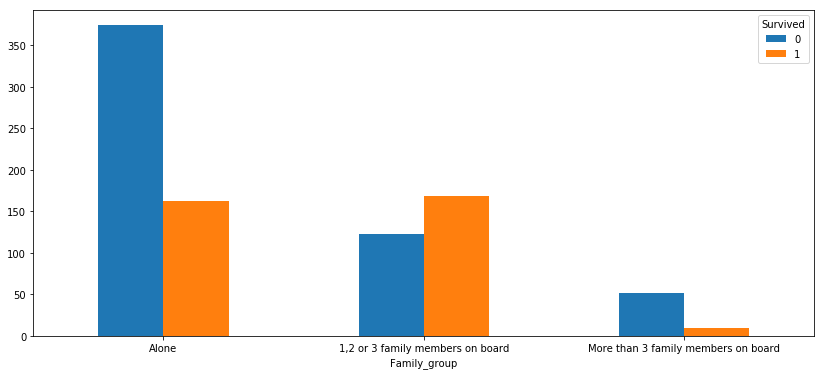

In [18]:
x=[0,1,2]
labels=['Alone','1,2 or 3 family members on board','More than 3 family members on board']

pd.crosstab(train['Family_group'], train['Survived'], normalize=False).plot(kind='bar', figsize=(14,6))

plt.xticks(x, labels, rotation=0)

plt.show()

#### Create 'Cabin_lettre' column, with the first letter of the cabin, or 'Z' if the cabin is not filled

In [19]:
train['Cabin_lettre'] = train['Cabin'].fillna('Z').apply(lambda x : str(x)[0])
test_users['Cabin_lettre'] = test_users['Cabin'].fillna('Z').apply(lambda x : str(x)[0])

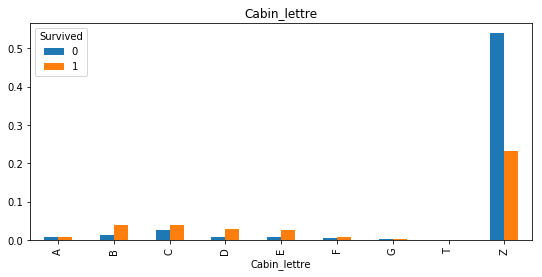

In [20]:
graph_crosstab(feature='Cabin_lettre', normalize=True)

In [21]:
train['Cabin_lettre_group']=int(2)
train.loc[train['Cabin_lettre']=='Z', 'Cabin_lettre_group']=0
train.loc[train['Cabin_lettre']=='A', 'Cabin_lettre_group']=1
train.loc[train['Cabin_lettre']=='G', 'Cabin_lettre_group']=1

test_users['Cabin_lettre_group']=int(2)
test_users.loc[train['Cabin_lettre']=='Z', 'Cabin_lettre_group']=0
test_users.loc[train['Cabin_lettre']=='A', 'Cabin_lettre_group']=1
test_users.loc[train['Cabin_lettre']=='G', 'Cabin_lettre_group']=1

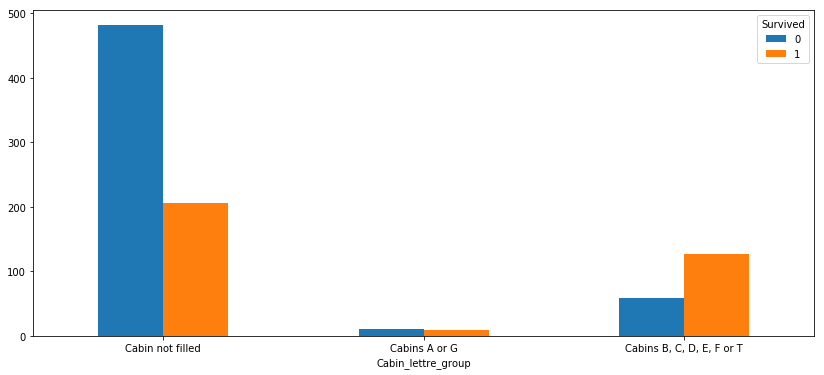

In [22]:
x=[0,1,2]
labels=['Cabin not filled','Cabins A or G','Cabins B, C, D, E, F or T']

pd.crosstab(train['Cabin_lettre_group'], train['Survived'], normalize=False).plot(kind='bar', figsize=(14,6))

plt.xticks(x, labels, rotation=0)

plt.show()

#### Create 'Ticket_lettre' column with the first letter of the ticket

In [23]:
train['Ticket_lettre'] = train['Ticket'].apply(lambda x : str(x)[0])
test_users['Ticket_lettre'] = test_users['Ticket'].apply(lambda x : str(x)[0])

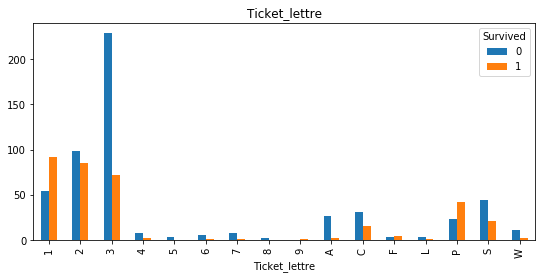

In [24]:
graph_crosstab(feature='Ticket_lettre', normalize=False)

### 4 - Fill & Transformation into dummies columns

#### Fill 'Embarked' with the same harbour than a family member, or with the most representative harbour 'S'

In [25]:
train['Embarked']=train['Embarked'].fillna('S')

#### Fill 'Fare' with the mean of 'Pclass'

In [26]:
test_users.loc[(test_users['Fare'].isnull())&(test_users['Pclass']==3), 'Fare']=int(np.mean(test_users['Fare'][test_users['Pclass']==3]))

#### Transform string col Sex into binary one

In [27]:
sex_index = ['male', 'female']

sex_dico=dict()
from_str_to_int(data=train, cat_index=sex_index, cat='Sex', cat_dico=sex_dico)

sex_dico_test=dict()
from_str_to_int(data=test_users, cat_index=sex_index, cat='Sex', cat_dico=sex_dico_test)

In [28]:
# Dummy variables pour les Embarked
train = pd.get_dummies(train, columns=['Embarked'])
test_users = pd.get_dummies(test_users, columns=['Embarked'])

# Dummy variables for Titre_int
train = pd.get_dummies(train, columns=['Titre_int'])
test_users = pd.get_dummies(test_users, columns=['Titre_int'])

# Dummy variables for Family_group
train = pd.get_dummies(train, columns=['Family_group'])
test_users = pd.get_dummies(test_users, columns=['Family_group'])

# Dummy variables for Cabin_lettre
train = pd.get_dummies(train, columns=['Cabin_lettre'])
test_users = pd.get_dummies(test_users, columns=['Cabin_lettre'])

# Dummy variables pour Cabin_lettre_group
train = pd.get_dummies(train, columns=['Cabin_lettre_group'])
test_users = pd.get_dummies(test_users, columns=['Cabin_lettre_group'])

# Dummy variables pour Ticket_lettre
train = pd.get_dummies(train, columns=['Ticket_lettre'])
test_users = pd.get_dummies(test_users, columns=['Ticket_lettre'])

#### Fill 'Age' with the mean of ages by titles ?

In [29]:
def fill_age_with_titre(data):
    cat_titre=list((train['Titre'].cat.categories))
    for i in cat_titre:
        data.loc[data['Titre']==i, 'Age']=data.loc[data['Titre']==i, 'Age'].fillna(int(np.mean(train['Age'][train['Titre']==i])))
    return

#### Study different ways to fill 'Age'

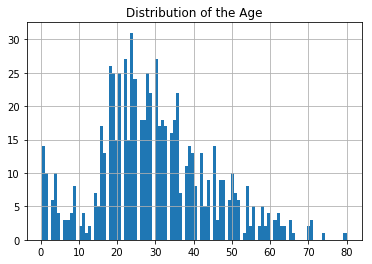

In [30]:
train.Age.hist(bins=100)
plt.title('Distribution of the Age')
plt.show()

In [31]:
# Creation d'un df concat df_age et df_noage
df_age=pd.concat([train[train['Age'].isnull()==False].set_index('PassengerId', drop=True), test_users[test_users['Age'].isnull()==False].set_index('PassengerId', drop=True)], axis=0, )
df_noage=pd.concat([train[train['Age'].isnull()==True].set_index('PassengerId', drop=True), test_users[test_users['Age'].isnull()==True].set_index('PassengerId', drop=True)], axis=0)        

In [32]:
# Suppression des colonnes non binaire
suppr = ['Cabin','Family','Last_Name','Name','Survived','Ticket','Titre', 'Cabin_lettre_T','Ticket_lettre_5','Ticket_lettre_8']
for i in suppr:
    del df_age[i]
    del df_noage[i]

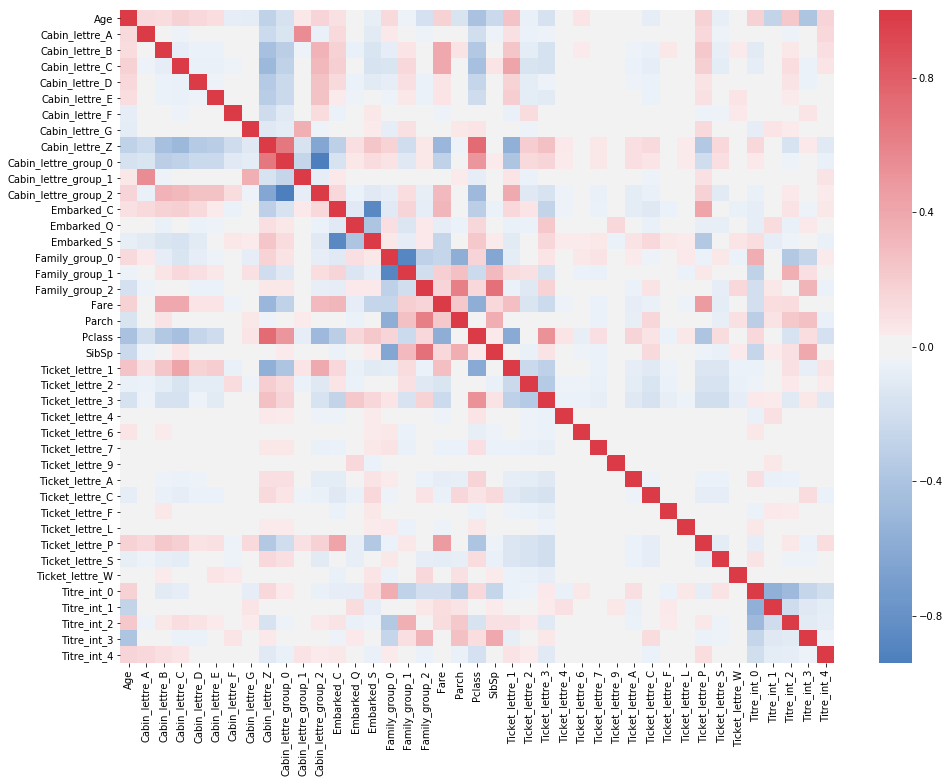

Index([u'Age', u'Cabin_lettre_C', u'Cabin_lettre_Z', u'Cabin_lettre_group_0',
       u'Cabin_lettre_group_2', u'Family_group_2', u'Fare', u'Pclass',
       u'SibSp', u'Ticket_lettre_1', u'Ticket_lettre_3', u'Ticket_lettre_P',
       u'Titre_int_0', u'Titre_int_1', u'Titre_int_2', u'Titre_int_3'],
      dtype='object')


In [33]:
# Matrice de correlation et selection des features les plus utiles
cor_matrix_age = df_age.corr().round(2)
fig = plt.figure(figsize=(16,12));

sns.heatmap(cor_matrix_age, annot=False, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
plt.show()

correlated_features_age = cor_matrix_age.index[cor_matrix_age.Age.abs()>.15][:-1]
print(correlated_features_age)

In [34]:
# AFFICHAGE DU MSE POUR LA PREDICTION DU NOUVEAU MODEL

target_age = df_age['Age'].astype(int).values
features_age = df_age[correlated_features_age[1:]].values

#my_LR = LogisticRegression(penalty='l1')
#my_LR = RandomForestRegressor()
my_LR = Ridge()
my_LR = GradientBoostingRegressor()

my_LR = my_LR.fit(features_age, target_age)



print('MSE with estimated model : ',mean_squared_error(target_age, my_LR.predict(features_age)))

('MSE with estimated model : ', 91.641859750810696)


In [35]:
# Comparaison avec le model ou on fill l'age avec la mean value en fonction du titre

df_old_model = pd.concat([train[train['Age'].isnull()==False].set_index('PassengerId', drop=True), test_users[test_users['Age'].isnull()==False].set_index('PassengerId', drop=True)], axis=0, )
df_old_model = df_old_model[['Age','Titre']]

for i in df_old_model.index:
    df_old_model.loc[i,'Age_old']=df_old_model['Age'][df_old_model['Titre']==str(df_old_model.loc[i,'Titre'])].mean()
    
print('MSE with fill Age with the mean by title : ', mean_squared_error(df_old_model['Age'].values, df_old_model['Age_old'].values))

('MSE with fill Age with the mean by title : ', 145.16292444772134)


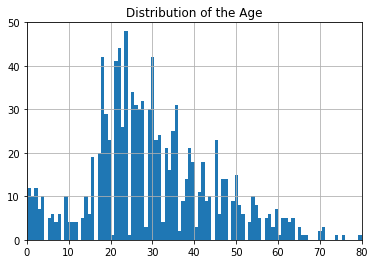

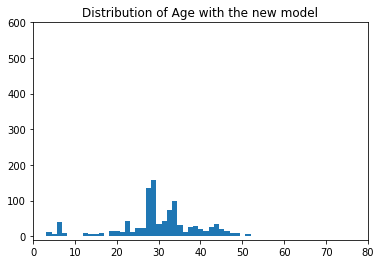

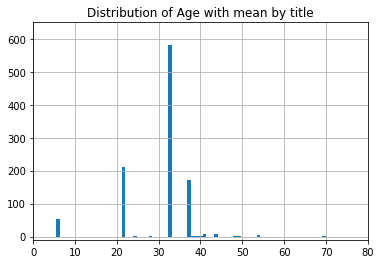

In [36]:
df_age['Age'].hist(bins=100)
plt.axis([0,80,0,50])
plt.title('Distribution of the Age')
plt.show()
plt.hist(my_LR.predict(features_age), bins=50)
plt.title('Distribution of Age with the new model')
plt.axis([0,80,-10,600])
plt.show()
df_old_model['Age_old'].hist(bins=70)
plt.axis([0,80,-10,650])
plt.title('Distribution of Age with mean by title')
plt.show()

##### This model has a better MSE but lower results on Kaggle competition. Then we fill Age with the mean by title

In [37]:
fill_age_with_titre(train)
fill_age_with_titre(test_users)

### 5 - scaling Fare & Age (not revelant)

In [38]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Imputer
mm_fare_scaler = MinMaxScaler()

In [39]:
#test_users.Fare = mm_fare_scaler.fit_transform(test_users[['Fare']])
#test_users.Age = mm_fare_scaler.fit_transform(test_users[['Age']])

## III - Learning algorithm
### 1 - Cross Validation on different models

In [40]:
features_of_interest_CrossVal_1=["Pclass", "Parch", "SibSp", "Sex", "Age", "Fare",
                         'Titre_int_0', "Titre_int_1", "Titre_int_2", "Titre_int_3", "Titre_int_4",
                         "Embarked_C", "Embarked_Q", "Embarked_S",
                         'Cabin_lettre_A', 'Cabin_lettre_B', 'Cabin_lettre_C', 'Cabin_lettre_D', 
                         'Cabin_lettre_E', 'Cabin_lettre_F', 'Cabin_lettre_G', 'Cabin_lettre_Z',
                         'Cabin_lettre_group_0', 'Cabin_lettre_group_1', 'Cabin_lettre_group_2',
                         'Family_group_0', 'Family_group_1', 'Family_group_2',
                         'Ticket_lettre_1', 'Ticket_lettre_2', 'Ticket_lettre_3', 'Ticket_lettre_4', 
                         'Ticket_lettre_6', 'Ticket_lettre_7', 'Ticket_lettre_9', 'Ticket_lettre_A', 
                         'Ticket_lettre_C', 'Ticket_lettre_F', 'Ticket_lettre_L', 'Ticket_lettre_P', 
                         'Ticket_lettre_S', 'Ticket_lettre_W']

#### Heat Map
#### Selection of the most correlated features (not revelant)

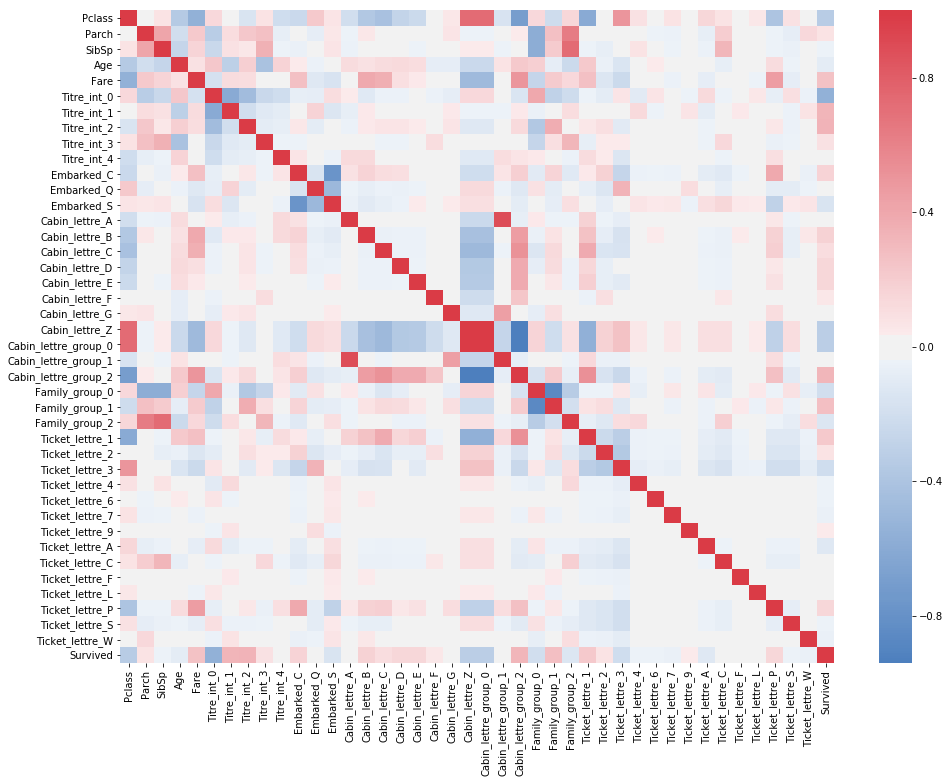

In [41]:
cor_matrix = train[features_of_interest_CrossVal_1+['Survived']].corr().round(2)
# Plotting heatmap 
fig = plt.figure(figsize=(16,12));

sns.heatmap(cor_matrix, annot=False, center=0, cmap = sns.diverging_palette(250, 10, as_cmap=True), ax=plt.subplot(111));
plt.show()

In [47]:
correlated_features = cor_matrix.index[cor_matrix.Survived.abs()>.1][:-1]
print(correlated_features)

features_of_interest_CrossVal=correlated_features

Index([u'Pclass', u'Fare', u'Titre_int_0', u'Titre_int_1', u'Titre_int_2',
       u'Embarked_C', u'Embarked_S', u'Cabin_lettre_B', u'Cabin_lettre_C',
       u'Cabin_lettre_D', u'Cabin_lettre_E', u'Cabin_lettre_Z',
       u'Cabin_lettre_group_0', u'Cabin_lettre_group_2', u'Family_group_0',
       u'Family_group_1', u'Family_group_2', u'Ticket_lettre_1',
       u'Ticket_lettre_3', u'Ticket_lettre_A', u'Ticket_lettre_P'],
      dtype='object')


In [48]:
cor_matrix.index[cor_matrix.Survived.abs()>.1][:-1]

Index([u'Pclass', u'Fare', u'Titre_int_0', u'Titre_int_1', u'Titre_int_2',
       u'Embarked_C', u'Embarked_S', u'Cabin_lettre_B', u'Cabin_lettre_C',
       u'Cabin_lettre_D', u'Cabin_lettre_E', u'Cabin_lettre_Z',
       u'Cabin_lettre_group_0', u'Cabin_lettre_group_2', u'Family_group_0',
       u'Family_group_1', u'Family_group_2', u'Ticket_lettre_1',
       u'Ticket_lettre_3', u'Ticket_lettre_A', u'Ticket_lettre_P'],
      dtype='object')

#### Selection of all features

In [48]:
features_of_interest_CrossVal=features_of_interest_CrossVal_1

In [49]:
X_train = train[features_of_interest_CrossVal]
X_Survived = train['Survived']

def fun_cross_val_score(my_MODEL, algo, cv=20):
    scores = cross_val_score(my_MODEL, X_train, X_Survived, cv=cv)
    print("Accuracy %s: %0.4f (+/- %0.2f)" % (algo ,scores.mean(), scores.std() * 2))
    if 'opti' in algo:
        print('='*30)
    return

In [50]:
models=dict()
models['Random Forest']=RandomForestClassifier()

models['Logistic Regression'] = LogisticRegression()

models['Ada Boost'] = AdaBoostClassifier()
models ['Knn']= KNeighborsClassifier()

models['Gradient Boosting Classifier'] = GradientBoostingClassifier()

models['Decision Tree Classifier'] = DecisionTreeClassifier()

models['SVC'] = SVC()

In [51]:
for key, value in models.items():
    fun_cross_val_score(value, key)

Accuracy Knn: 0.7263 (+/- 0.13)
Accuracy Decision Tree Classifier: 0.7928 (+/- 0.11)
Accuracy Gradient Boosting Classifier: 0.8374 (+/- 0.10)
Accuracy SVC: 0.7577 (+/- 0.14)
Accuracy Logistic Regression: 0.8293 (+/- 0.11)
Accuracy Ada Boost: 0.8126 (+/- 0.13)
Accuracy Random Forest: 0.8226 (+/- 0.13)


In [52]:
list_models=list()
for k,v in models.items():
    list_models.append((k,v))

In [53]:
fun_cross_val_score(VotingClassifier(estimators=list_models, voting='hard'), 'Voting Classifier')

Accuracy Voting Classifier: 0.8317 (+/- 0.10)


### 2 - Optimization of these models

#### Defining function to export/import optimized parameters

In [54]:
def optim_save_best_params(parameters, estimator, path_ = path, cv = 10):
    
    my_estimator = estimator
    my_cv = GridSearchCV(estimator = my_estimator, param_grid = parameters, cv = cv, n_jobs = 3, verbose = 2)
    my_cv.fit(X_train, X_Survived)
    with open(path_ , 'w') as f:
        data= my_cv.best_params_
        json.dump(data, f)
    f.close()
    print(my_cv.best_params_)
    
def read_parameters(path_):
    with open(path_, 'r') as f:
        data = json.load(f)
    return data

#### Defining paths to log files

In [55]:
path_rf = path + '/Parameters/random_forest_parameters.json'
path_dt = path + '/Parameters/decision_tree_parameters.json'
path_lr = path + '/Parameters/linear_regression_parameters.json'
path_gb = path + '/Parameters/gradient_boosting_parameters.json'
path_ab = path + '/Parameters/ada_boosting_parameters.json'

#### Flag to train optimized parameters

In [56]:
trained = True

#### Defining parameters to explore

In [57]:
param_grid_RF = {'n_estimators' : range(10,101),
                 'min_samples_split' : range(2, 8),
                 'max_leaf_nodes' : range(8, 16),
                 'max_depth' : range(10, 14),
                'criterion':['gini', 'entropy']}
param_grid_LR = {'penalty' : ['l1', 'l2'], 
                 'C':np.array(range(5, 16))/10}

param_grid_AB = {'n_estimators':[i for i in range(10, 101)]}

param_grid_GB = {'n_estimators':range(10, 101),
                 'min_samples_split':range(2,8),
                 'max_depth':range(2,10)}

param_grid_DT = {'criterion':['entropy', 'gini'],
                 'splitter':['random', 'best'],
                 'min_samples_split':range(2, 15),  
                 'min_samples_leaf':range(2,15),
                 'max_leaf_nodes':range(10, 20)}

#### Optimizing algorithms

In [58]:
if trained == False:

   # optim_save_best_params(parameters = param_grid_RF, 
   #                    estimator=RandomForestClassifier(),
   #                    path_ = path_rf)
   # optim_save_best_params(parameters = param_grid_AB, 
   #                    estimator=AdaBoostClassifier(base_estimator=LogisticRegression()),
   #                    path_ = path_ab)
   # optim_save_best_params(parameters = param_grid_LR, 
   #                    estimator=LogisticRegression(),
   #                    path_ = path_lr)
   # optim_save_best_params(parameters = param_grid_GB, 
   #                    estimator=GradientBoostingClassifier(),
   #                    path_ = path_gb)
    optim_save_best_params(parameters = param_grid_DT, 
                       estimator=DecisionTreeClassifier(),
                       path_ = path_dt)

trained = True

### 3 - Cross Validation on optimized models

In [59]:
opti_mod=dict()
opti_mod['Random Forest']=RandomForestClassifier()
opti_mod['Random Forest opti']=RandomForestClassifier().set_params(**read_parameters(path_rf))

opti_mod['Logistic Regression'] = LogisticRegression()
opti_mod['Logistic Regression opti'] = LogisticRegression().set_params(**read_parameters(path_lr))

opti_mod['Ada Boost'] = AdaBoostClassifier(base_estimator=LogisticRegression())
opti_mod['Ada Boost opti'] = AdaBoostClassifier(base_estimator=LogisticRegression()).set_params(**read_parameters(path_ab))

opti_mod['Gradient Boosting Classifier'] = GradientBoostingClassifier()
opti_mod['Gradient Boosting Classifier opti'] = GradientBoostingClassifier().set_params(**read_parameters(path_gb))

opti_mod['Decision Tree Classifier'] = DecisionTreeClassifier()
opti_mod['Decision Tree Classifier opti'] = DecisionTreeClassifier().set_params(**read_parameters(path_dt))

IOError: [Errno 2] No such file or directory: 'C:\\Users\\Romain\\Documents\\230 - MSc ESSEC\\304 - Machine Learning\\02 - Kaggle Titanic/Parameters/random_forest_parameters.json'

In [ ]:
for key, value in opti_mod.items():
    fun_cross_val_score(value, key)

In [ ]:
list_models_opti=list()
for k,v in opti_mod.items():
    if 'opti' in k:
        list_models_opti.append((k,v))

In [ ]:
fun_cross_val_score(VotingClassifier(estimators=list_models_opti, voting='hard'), 'Voting Classifier')

### 4 - Function submit

In [ ]:
def submit_kaggle(model=SVC() , name='Model'):
    target_MODEL = train['Survived'].values

    features_of_interest_MODEL=features_of_interest_CrossVal

    features_MODEL = train[features_of_interest_MODEL].values

    my_MODEL = model

    my_MODEL = my_MODEL.fit(features_MODEL, target_MODEL)

#    print('Score of '+name+' : ',my_MODEL.score(features_MODEL, target_MODEL))

    test_features_MODEL = test_users[features_of_interest_MODEL].values

    my_prediction_MODEL = my_MODEL.predict(test_features_MODEL)

    PassengerId =np.array(test_users["PassengerId"]).astype(int)
    my_solution_MODEL = pd.DataFrame(my_prediction_MODEL, PassengerId, columns = ["Survived"])

    return my_solution_MODEL.to_csv("my_solution_"+str(name)+".csv", index_label = ["PassengerId"])

### 5 - Submission on Kaggle
#### (i) - Not optimized (with scaling & features selected)

In [ ]:
for k,v in opti_mod.items():
    if 'opti' not in k:
        submit_kaggle(v, k)
submit_kaggle(VotingClassifier(estimators=list_models, voting='hard'), 'Voting Classifier')

In [ ]:
print('Score Kaggle of Random Forest : 0.77511')
print('Score Kaggle of Logistic Regression : 0.78468')
print('Score Kaggle of Ada Boost : 0.78468')
print('Score Kaggle of Gradient Boosting Classifier : 0.79425')
print('Score Kaggle of Decision Tree Classifier : 0.72248')
print('Score Kaggle of Voting Classifier : 0.79425')

#### (ii) - Optimized (with scaling & features selected)

In [ ]:
for k,v in opti_mod.items():
    if 'opti' in k:
        submit_kaggle(v, k)
submit_kaggle(VotingClassifier(estimators=list_models_opti, voting='hard'), 'Voting Classifier opti')

In [ ]:
print('Score Kaggle of Random Forest Opti : 0.79425')
print('Score Kaggle of Logistic Regression Opti : ')
print('Score Kaggle of Ada Boost Opti : ')
print('Score Kaggle of Gradient Boosting Classifier Opti : 0.75119')
print('Score Kaggle of Decision Tree Classifier Opti : ')
print('Score Kaggle of Voting Classifier Opti : 0.78947')

#### (iii) - Not optimized (without scaling & all features)

In [ ]:
for k,v in opti_mod.items():
    if 'opti' not in k:
        submit_kaggle(v, k)
submit_kaggle(VotingClassifier(estimators=list_models, voting='hard'), 'Voting Classifier')

In [ ]:
print('Score Kaggle of Random Forest : ')
print('Score Kaggle of Logistic Regression : ')
print('Score Kaggle of Ada Boost : ')
print('Score Kaggle of Gradient Boosting Classifier : ')
print('Score Kaggle of Decision Tree Classifier : ')
print('Score Kaggle of Voting Classifier : ')

#### (iv) - Optimized (without scaling & all features)

In [ ]:
for k,v in opti_mod.items():
    if 'opti' in k:
        submit_kaggle(v, k)
submit_kaggle(VotingClassifier(estimators=list_models_opti, voting='hard'), 'Voting Classifier opti')

In [ ]:
print('Score Kaggle of Random Forest Opti : 0.79425')
print('Score Kaggle of Logistic Regression Opti : ')
print('Score Kaggle of Ada Boost Opti : ')
print('Score Kaggle of Gradient Boosting Classifier Opti : 0.75119')
print('Score Kaggle of Decision Tree Classifier Opti : ')
print('Score Kaggle of Voting Classifier Opti : 0.78947')

#### (v) - Optimized with Kaggle (sans le scaling)
##### Random Forest with all features - score : 0.81339

In [ ]:
target_RF = train['Survived'].values
features_of_interest_RF=features_of_interest_CrossVal_1
features_RF = train[features_of_interest_RF].values

my_RF = RandomForestClassifier(n_estimators=21, min_samples_split=10, max_leaf_nodes=10, max_depth=10, random_state=0)
my_RF = my_RF.fit(features_RF, target_RF)

print(my_RF.score(features_RF, target_RF))

feature_of_importance = (sorted(zip(map(lambda x: round(int(x*10000)/100, 15), my_RF.feature_importances_), features_of_interest_RF), 
             reverse=False))
features=pd.DataFrame()
for i in range(len(feature_of_importance)):
    features.loc[i, 'Feature']=feature_of_importance[i][1]
    features.loc[i, 'Score']=feature_of_importance[i][0]
    
features.set_index('Feature', inplace=True)
features.plot(kind='barh', figsize=(9,9), title='Features importance')

test_features_RF = test_users[features_of_interest_RF].values
my_prediction_RF = my_RF.predict(test_features_RF)
PassengerId =np.array(test_users["PassengerId"]).astype(int)
my_solution_RF = pd.DataFrame(my_prediction_RF, PassengerId, columns = ["Survived"])
my_solution_RF.to_csv("my_solution_RF_best.csv", index_label = ["PassengerId"])

##### Gradient Boosting Classifier with all features - 

In [ ]:
target_GB = train['Survived'].values
features_of_interest_GB=features_of_interest_CrossVal_1
features_GB = train[features_of_interest_GB].values

my_GB = GradientBoostingClassifier()
my_GB = my_GB.fit(features_GB, target_GB)

print(my_GB.score(features_GB, target_GB))

feature_of_importance = (sorted(zip(map(lambda x: round(int(x*10000)/100, 15), my_GB.feature_importances_), features_of_interest_GB), 
             reverse=False))
features=pd.DataFrame()
for i in range(len(feature_of_importance)):
    features.loc[i, 'Feature']=feature_of_importance[i][1]
    features.loc[i, 'Score']=feature_of_importance[i][0]
    
features.set_index('Feature', inplace=True)
features.plot(kind='barh', figsize=(9,9), title='Features importance')

test_features_GB = test_users[features_of_interest_GB].values
my_prediction_GB = my_GB.predict(test_features_GB)
PassengerId =np.array(test_users["PassengerId"]).astype(int)
my_solution_GB = pd.DataFrame(my_prediction_GB, PassengerId, columns = ["Survived"])
my_solution_GB.to_csv("my_solution_GB_best.csv", index_label = ["PassengerId"])

##### Voting Classifier with all features - Score 0.81818

In [ ]:
target_VC = train['Survived'].values

features_of_interest_VC=features_of_interest_CrossVal_1


features_VC = train[features_of_interest_VC].values

clf1 = LogisticRegression(random_state=0)
clf2 = RandomForestClassifier(n_estimators=21, min_samples_split=10, max_leaf_nodes=10, max_depth=10, random_state=0)


eclf = VotingClassifier(estimators=[('lr', clf1), 
                                    ('rf', clf2)], voting='hard')

my_VC = eclf.fit(features_VC, target_VC)

for clf, label in zip([clf1, 
                       clf2,
                       eclf], ['Logistic Regression', 'Random Forest', 'Ensemble']):
    scores = cross_val_score(clf, features_VC, target_VC, cv=15, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
print(my_VC.score(features_VC, target_VC))

test_features_VC = test_users[features_of_interest_VC].values

my_prediction_VC = my_VC.predict(test_features_VC)

PassengerId =np.array(test_users["PassengerId"]).astype(int)
my_solution_VC = pd.DataFrame(my_prediction_VC, PassengerId, columns = ["Survived"])

my_solution_VC.to_csv("my_solution_VC_best.csv", index_label = ["PassengerId"])